In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import random
import gc
import matplotlib.pyplot as plt

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def normalize_image(image):
    return image.astype(np.float32) / 255.0

def one_hot_encode_mask(mask, num_classes=8):
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for class_value in range(num_classes):
        one_hot[mask == class_value, class_value] = 1
    return one_hot

def make_divisible(image, patch_size):
    height, width = image.shape[:2]
    new_height = (height // patch_size) * patch_size
    new_width = (width // patch_size) * patch_size
    return image[:new_height, :new_width]

def create_patches(image, patch_size):
    patches = []
    height, width = image.shape[:2]
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
    return np.array(patches)

def random_horizontal_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def random_vertical_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

def random_rotate(image, mask, angle_range=(-30, 30)):
    angle = random.uniform(angle_range[0], angle_range[1])
    image = Image.fromarray((image * 255).astype(np.uint8))
    mask = Image.fromarray(np.argmax(mask, axis=-1).astype(np.uint8))
    image = image.rotate(angle, resample=Image.BICUBIC)
    mask = mask.rotate(angle, resample=Image.NEAREST)
    return np.array(image) / 255.0, one_hot_encode_mask(np.array(mask))

def random_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype(np.uint8)))
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))
    return np.array(image) / 255.0

def apply_augmentation(image, mask):
    image, mask = random_horizontal_flip(image, mask)
    image, mask = random_vertical_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image = random_brightness_contrast(image)
    return image, mask


In [ ]:
def process_all_images(image_folder, mask_folder, patch_size):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_image_patches, all_mask_patches = [], []

    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]
        corresponding_mask = next((mask for mask in mask_files if mask.startswith(image_name)), None)

        if corresponding_mask is None:
            print(f"Skipping {image_file}: no corresponding mask found.")
            continue

        image = np.array(Image.open(os.path.join(image_folder, image_file)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(mask_folder, corresponding_mask)).convert("L"))

        image = normalize_image(image)
        mask = one_hot_encode_mask(mask, num_classes=8)

        image = make_divisible(image, patch_size)
        mask = make_divisible(mask, patch_size)

        image, mask = apply_augmentation(image, mask)

        image_patches = create_patches(image, patch_size)
        mask_patches = create_patches(mask, patch_size)

        all_image_patches.extend(image_patches)
        all_mask_patches.extend(mask_patches)

    return np.array(all_image_patches), np.array(all_mask_patches)


In [ ]:
def apply_color_map(mask, color_map):
    class_mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*class_mask.shape, 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_mask[class_mask == class_value] = color
    return rgb_mask

def visualize_patches(image_patches, mask_patches, color_map, num_samples=10):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(image_patches))):
        image, mask = image_patches[i], mask_patches[i]
        colored_mask = apply_color_map(mask, color_map)

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image Patch {i + 1}')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(colored_mask)
        plt.axis('off')
        plt.title(f'Mask Patch {i + 1}')

    plt.tight_layout()
    plt.show()


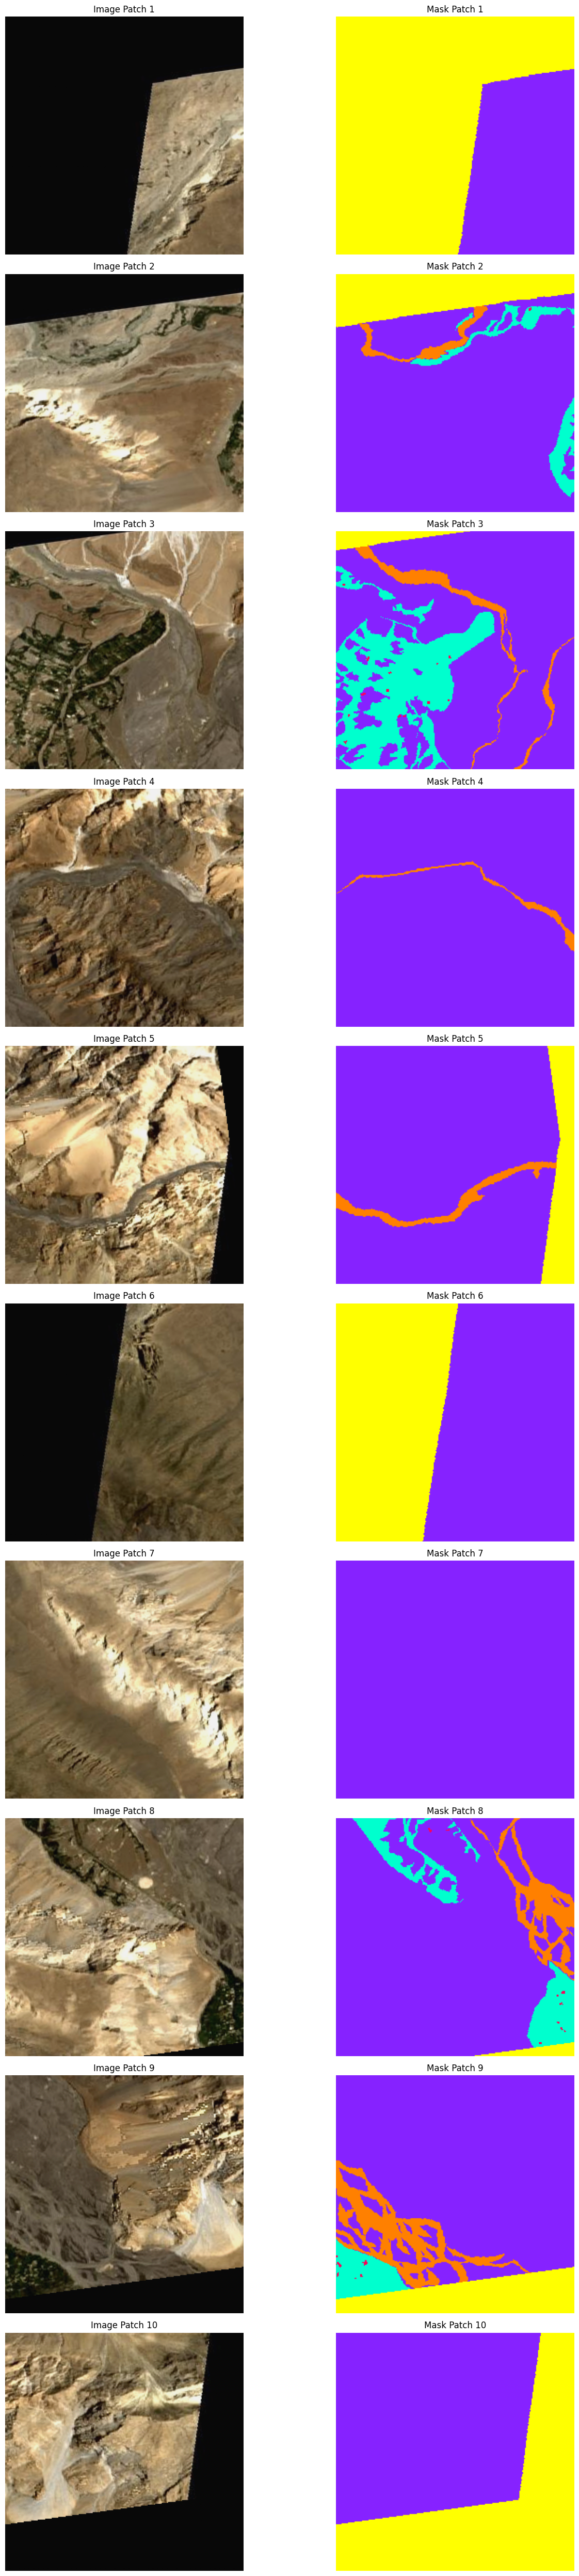

In [ ]:
image_folder = '/content/drive/MyDrive/originals'  # Replace with your folder path
mask_folder = '/content/drive/MyDrive/masks'       # Replace with your folder path
patch_size = 256

image_patches, mask_patches = process_all_images(image_folder, mask_folder, patch_size)
visualize_patches(image_patches, mask_patches, color_map, num_samples=10)


In [ ]:
!nvidia-smi

Sat Nov 30 19:42:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model

def decoder_block(input_tensor, skip_features, num_filters):
    """
    Decoder block for the U-Net model.

    Args:
        input_tensor: Input tensor to the decoder block.
        skip_features: Skip connection features from the encoder.
        num_filters: Number of filters for the convolutional layers.

    Returns:
        Output tensor of the decoder block.
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    # Load VGG16 with pre-trained weights, excluding its top layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze VGG16 layers to retain pre-trained weights
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder blocks from VGG16
    s1 = vgg16.get_layer('block1_conv2').output  # Skip connection 1
    s2 = vgg16.get_layer('block2_conv2').output  # Skip connection 2
    s3 = vgg16.get_layer('block3_conv3').output  # Skip connection 3
    s4 = vgg16.get_layer('block4_conv3').output  # Skip connection 4
    p4 = vgg16.get_layer('block5_conv3').output  # Bridge

    # Decoder blocks
    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    return Model(inputs=vgg16.input, outputs=outputs)

# Model summary
input_shape = (256, 256, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,855,112 (98.63 MB)

 Trainable params: 11,140,424 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

In [ ]:
from sklearn.model_selection import train_test_split
import gc

# Ensure that the image data matches the expected input shape for VGG16
# VGG16 expects input shape of (256, 256, 3) for images
image_patches = image_patches.reshape(-1, 256, 256, 3)

# Ensure masks are in the right shape for output layer (num_classes = 8 in your case)
mask_patches = mask_patches.reshape(-1, 256, 256, 8)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_patches, mask_patches, test_size=0.2, random_state=42)

# Free up memory
gc.collect()


14

In [ ]:
print(X_train.shape)  # Should output (num_train_samples, 256, 256, 3)
print(X_val.shape)  # Should output (num_val_samples, 256, 256, 3)

(672, 256, 256, 3)
(168, 256, 256, 3)


In [ ]:
import tensorflow as tf

print("Is GPU available?: ", tf.config.list_physical_devices('GPU'))
print("Device being used:\n", tf.test.gpu_device_name())

Is GPU available?:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device being used:
 /device:GPU:0


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input

# Ensure TensorFlow uses GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid reserving all GPU memory upfront
        print("GPU setup complete. Using:", tf.test.gpu_device_name())
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will run on CPU.")

# Apply VGG16-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Callbacks
checkpoint = ModelCheckpoint(
    'unet_model_epoch_{epoch:02d}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Ensure training on GPU
with tf.device('/GPU:0'):
    # Training the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=[checkpoint, early_stopping]
    )

# Optionally, save the final model after training is complete
model.save('final_vgg_unet_model.keras')


Physical devices cannot be modified after being initialized
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.4385 - loss: 66.4518 - mean_io_u: 0.3785 - val_accuracy: 0.6121 - val_loss: 5.7995 - val_mean_io_u: 0.3050
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4951 - loss: 4.0696 - mean_io_u: 0.2802 - val_accuracy: 0.5998 - val_loss: 2.0883 - val_mean_io_u: 0.3019
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6185 - loss: 1.7286 - mean_io_u: 0.2793 - val_accuracy: 0.6166 - val_loss: 1.5940 - val_mean_io_u: 0.3019
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6677 - loss: 1.3484 - mean_io_u: 0.2793 - val_accuracy: 0.6164 - val_loss: 1.3422 - val_mean_io_u: 0.3019
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6584 - loss: 1.2967 - mean_io_u: 0.2793 - val_accuracy: 0.6165 - val_loss: 1.3308 - val_mean_io_u: 0.3019
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6677 - loss: 1.2602 - me

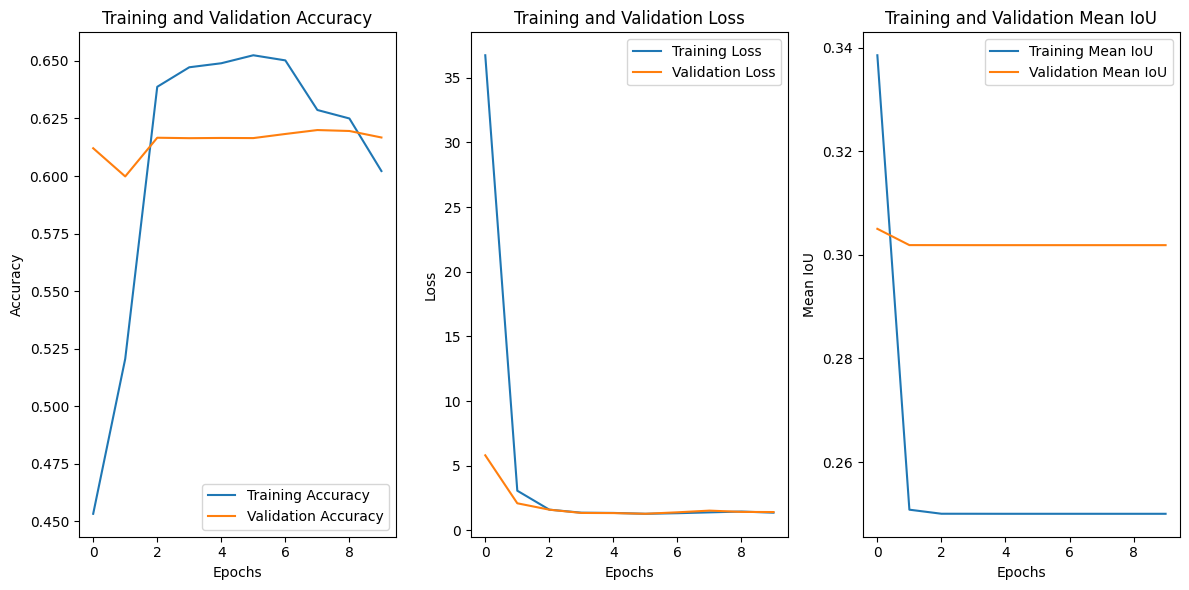

In [ ]:
import matplotlib.pyplot as plt

# Visualize Training & Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean IoU
plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'], label='Training Mean IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Assuming you have trained the model and have the 'history' object
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1  # Best epoch based on validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])

final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

final_train_miou = history.history['mean_io_u'][-1]
final_val_miou = history.history['val_mean_io_u'][-1]

# Print the results
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Best Epoch (Validation Accuracy): {best_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"Final Training Mean IoU: {final_train_miou:.4f}")
print(f"Final Validation Mean IoU: {final_val_miou:.4f}")


Final Training Accuracy: 0.6022
Final Validation Accuracy: 0.6167
Best Epoch (Validation Accuracy): 8
Best Validation Accuracy: 0.6200
Final Training Loss: 1.3621
Final Validation Loss: 1.4113
Final Training Mean IoU: 0.2500
Final Validation Mean IoU: 0.3019


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


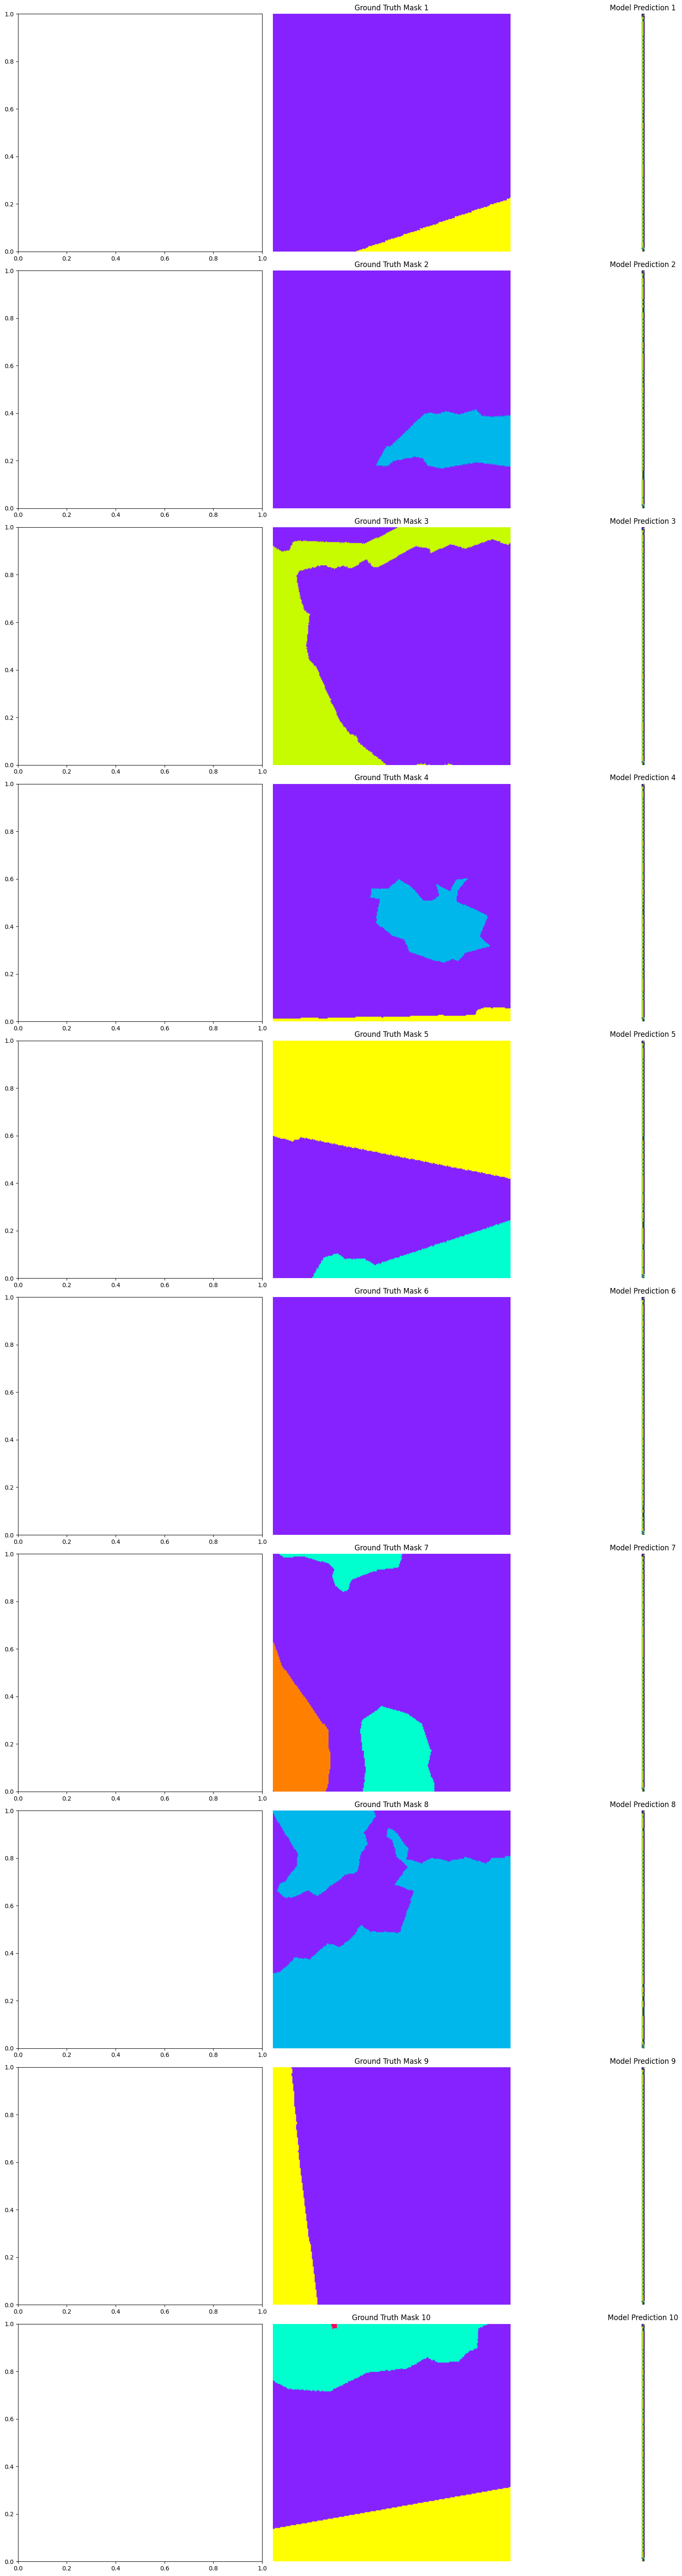

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

# Function to apply the color map to a mask
def apply_color_map(mask, color_map):
    class_mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*class_mask.shape, 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_mask[class_mask == class_value] = color
    return rgb_mask

# Number of samples you want to visualize
num_samples = 10

# Create a figure with enough subplots to display the images
fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))

# Loop through the samples
for i in range(num_samples):
    image = X_val[i]  # Your validation image
    mask = y_val[i]  # Your ground truth mask

    # If the image is normalized, undo the normalization (multiply by 255)
    # Assuming image was previously divided by 255.0 in preprocessing
    image = image * 255.0 if image.max() <= 1 else image  # Revert if it's normalized

    # Predict using the model
    prediction = model.predict(np.expand_dims(image, axis=0))  # Add batch dimension
    prediction = prediction.squeeze()  # Remove batch dimension

    # Convert the multi-channel prediction to a single-channel image by selecting the channel with the highest probability or using argmax
    predicted_mask = np.argmax(prediction, axis=-1)

    # Apply the color map to both the ground truth mask and predicted mask
    colored_mask = apply_color_map(mask, color_map)
    colored_pred_mask = apply_color_map(predicted_mask, color_map)

    # Visualizing the original image, mask, and prediction for the current sample
    axes[i, 0].imshow(image.astype(np.uint8))  # Show original image in color
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(colored_mask)  # Display the ground truth mask with color
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(colored_pred_mask)  # Display the model prediction with color
    axes[i, 2].set_title(f'Model Prediction {i+1}')
    axes[i, 2].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


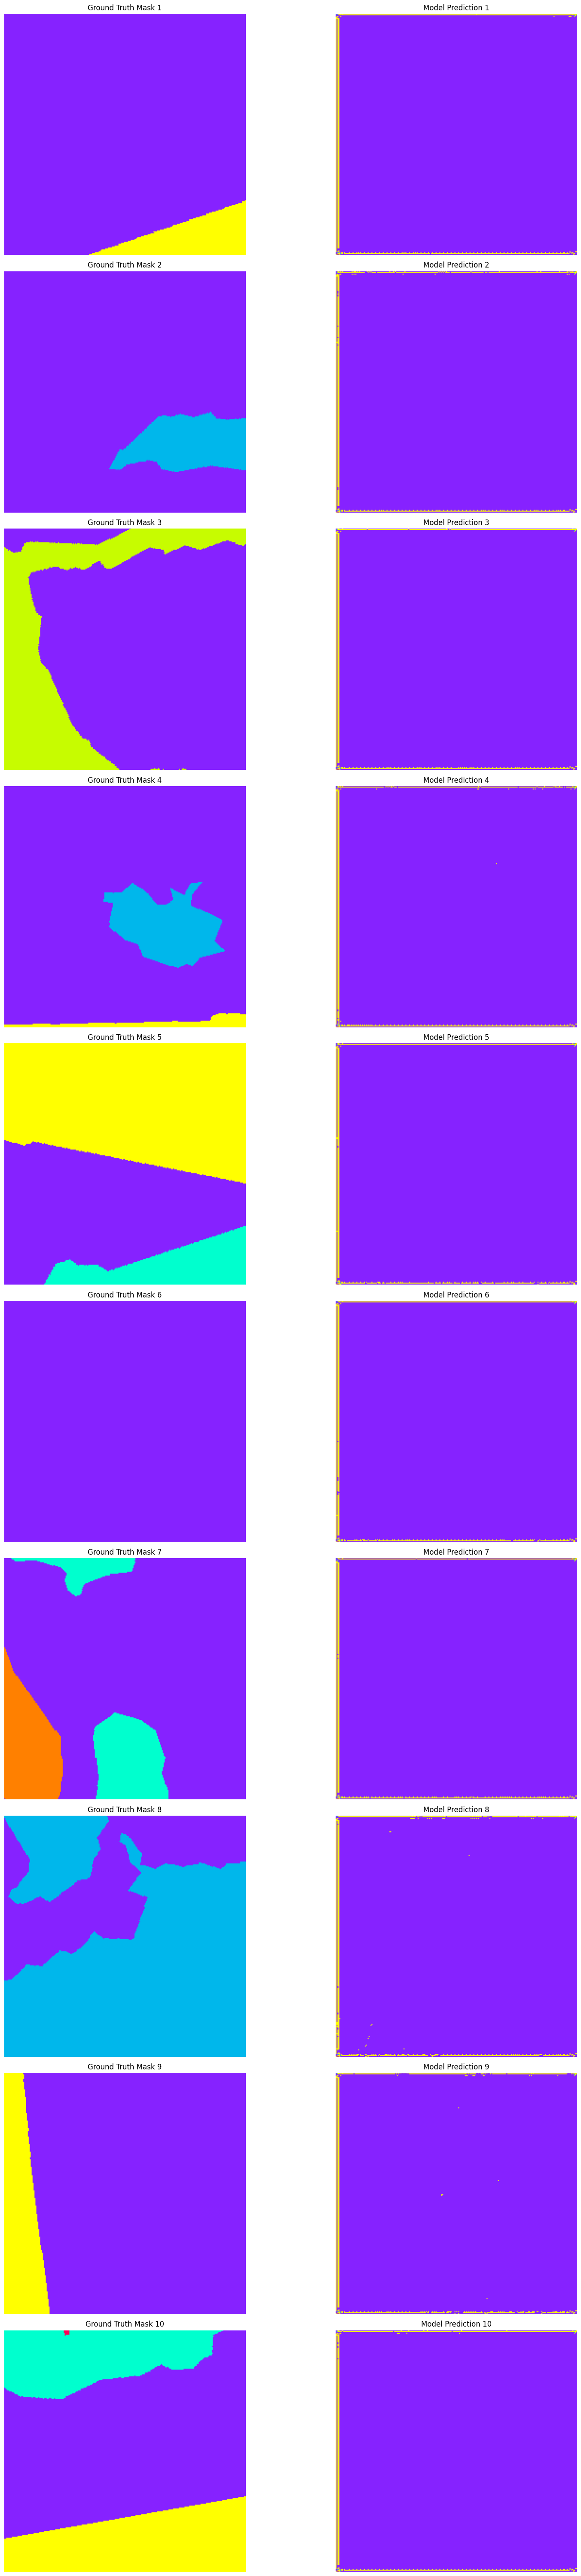

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

# Function to apply the color map to a mask
def apply_color_map(mask, color_map):
    class_mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*class_mask.shape, 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_mask[class_mask == class_value] = color
    return rgb_mask

# Number of samples you want to visualize
num_samples = 10

# Create a figure with enough subplots to display the images
fig, axes = plt.subplots(num_samples, 2, figsize=(18, 6 * num_samples))

# Loop through the samples
for i in range(num_samples):
    mask = y_val[i]  # Your ground truth mask

    # Predict using the model
    prediction = model.predict(np.expand_dims(X_val[i], axis=0))  # Add batch dimension
    prediction = prediction.squeeze()  # Remove batch dimension

    # If you're working with a binary segmentation, ensure to apply a threshold
    # Apply the threshold to classify the output (e.g., for binary segmentation)
    threshold = 0.5
    predicted_mask = (prediction > threshold).astype(np.uint8)

    # Apply the color map to both the ground truth mask and predicted mask
    colored_mask = apply_color_map(mask, color_map)
    colored_pred_mask = apply_color_map(predicted_mask, color_map)

    # Visualizing the ground truth mask and prediction for the current sample
    axes[i, 0].imshow(colored_mask)  # Display the ground truth mask with color
    axes[i, 0].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(colored_pred_mask)  # Display the model prediction with color
    axes[i, 1].set_title(f'Model Prediction {i+1}')
    axes[i, 1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# Ensure TensorFlow uses GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid reserving all GPU memory upfront
        print("GPU setup complete. Using:", tf.test.gpu_device_name())
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Training will run on CPU.")

# Apply VGG16-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Callbacks
checkpoint = ModelCheckpoint(
    'unet_model_epoch_{epoch:02d}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tensorboard = TensorBoard(log_dir='logs/fit', histogram_freq=1)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Ensure training on GPU
with tf.device('/GPU:0'):
    # Compile model with Adam optimizer and categorical crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', MeanIoU(num_classes=8)]
    )

    # Training the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[checkpoint, early_stopping, tensorboard, reduce_lr]
    )

# Optionally, save the final model after training is complete
model.save('final_vgg_unet_model_1.keras')


GPU setup complete. Using: /device:GPU:0


NameError: name 'X_train' is not defined

In [ ]:

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
